In [1]:
import geopandas as gpd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
import rioxarray
from levee_hunter.get_mask import get_mask
from levee_hunter.segmentation_dataset import SegmentationDataset


import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# Load the images
data_dir = "../data/raw/w2-Lidar"
tif_files = [file for file in os.listdir(data_dir) if file.endswith(".tif")]
images = [rioxarray.open_rasterio(os.path.join(data_dir, file)) for file in tif_files[:]]

# Load the levees data
levees_file = "../data/raw/w1-Kickoff/us_levees_n38w122.gpkg"
levees_data = gpd.read_file(levees_file)
levees_data_3717 = levees_data.to_crs("EPSG:3717")

In [3]:
# Now get masks for all images:
lidar_images_arr = []
targets_arr = []
for image in images:
    lidar_data, target = get_mask(image, levees_data_3717, invert=True)
    lidar_data = lidar_data.reshape(lidar_data.shape[1], lidar_data.shape[2])
    lidar_images_arr.append(lidar_data)
    targets_arr.append(target)

lidar_images_arr = np.array(lidar_images_arr)
targets_arr = np.array(targets_arr)

lidar_images_arr.shape

(22, 3000, 3000)

0


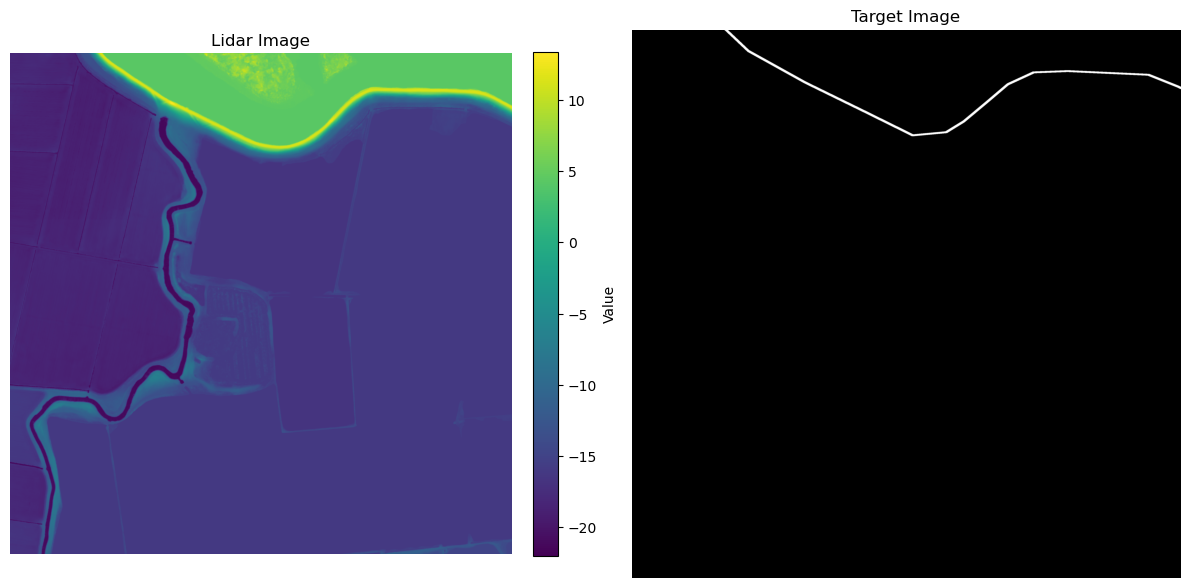

1


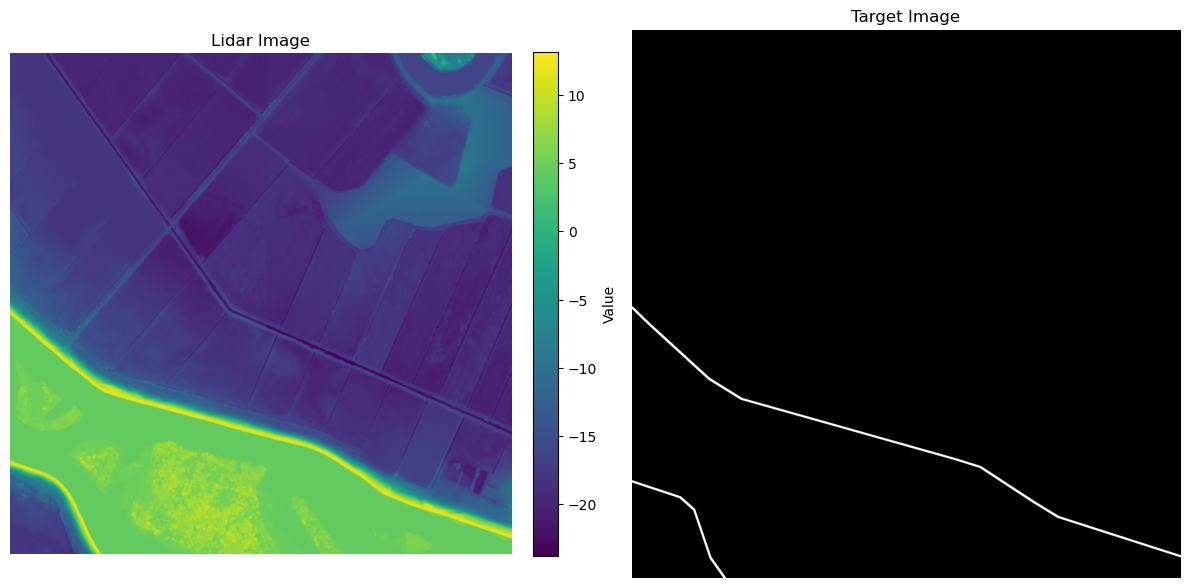

2


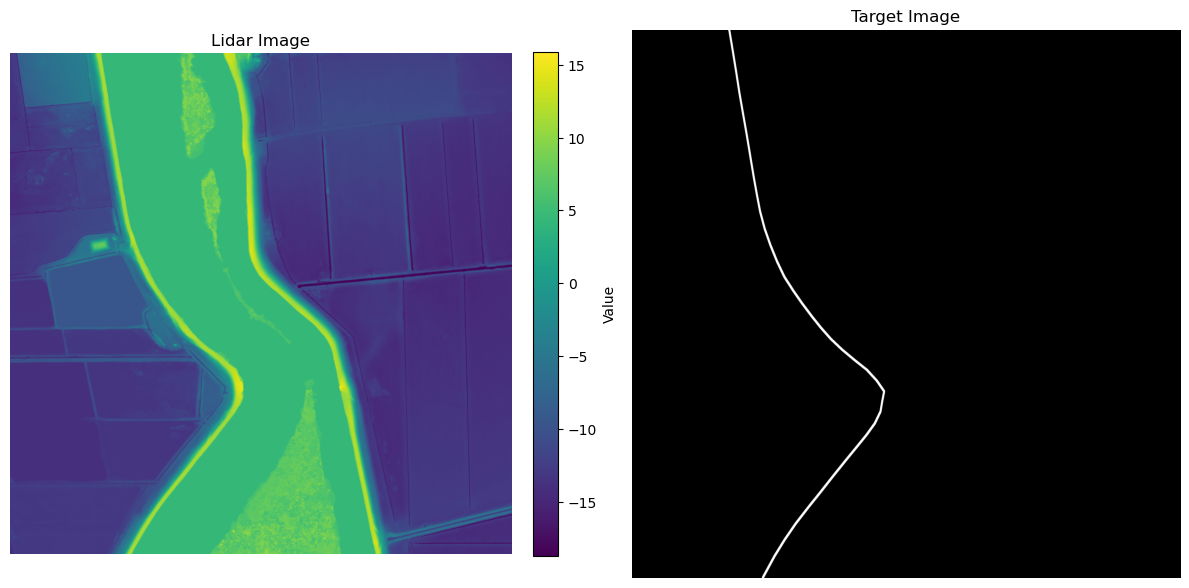

3


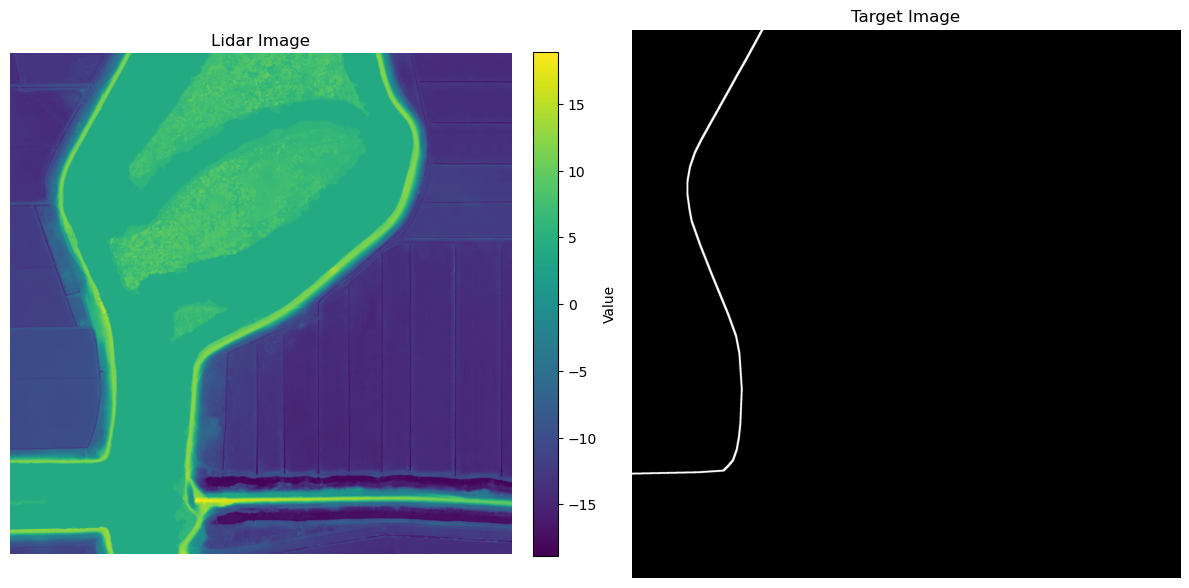

4


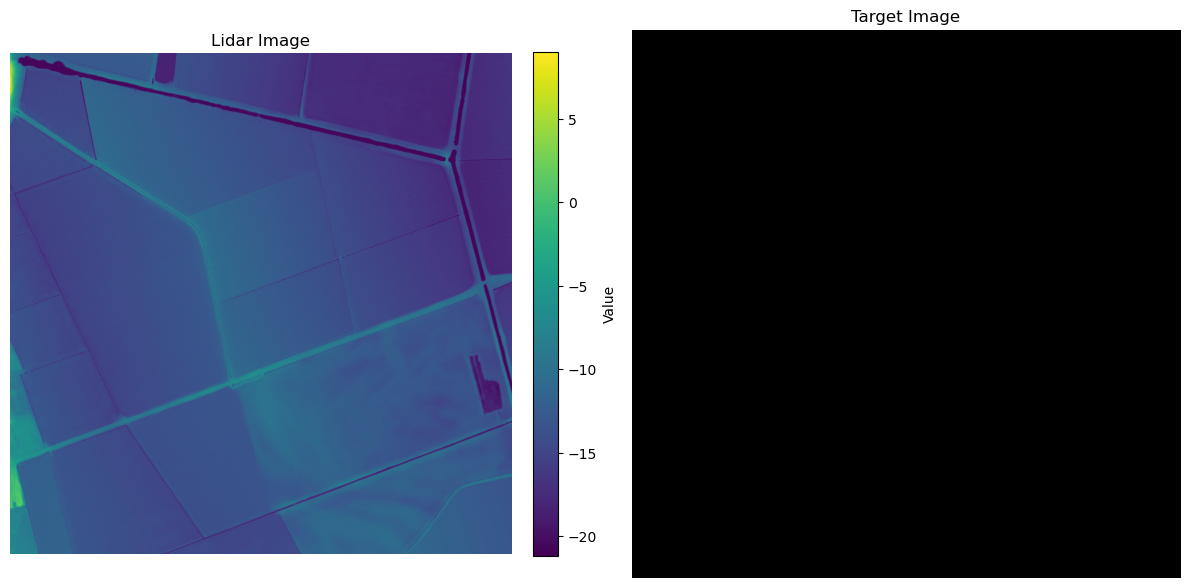

5


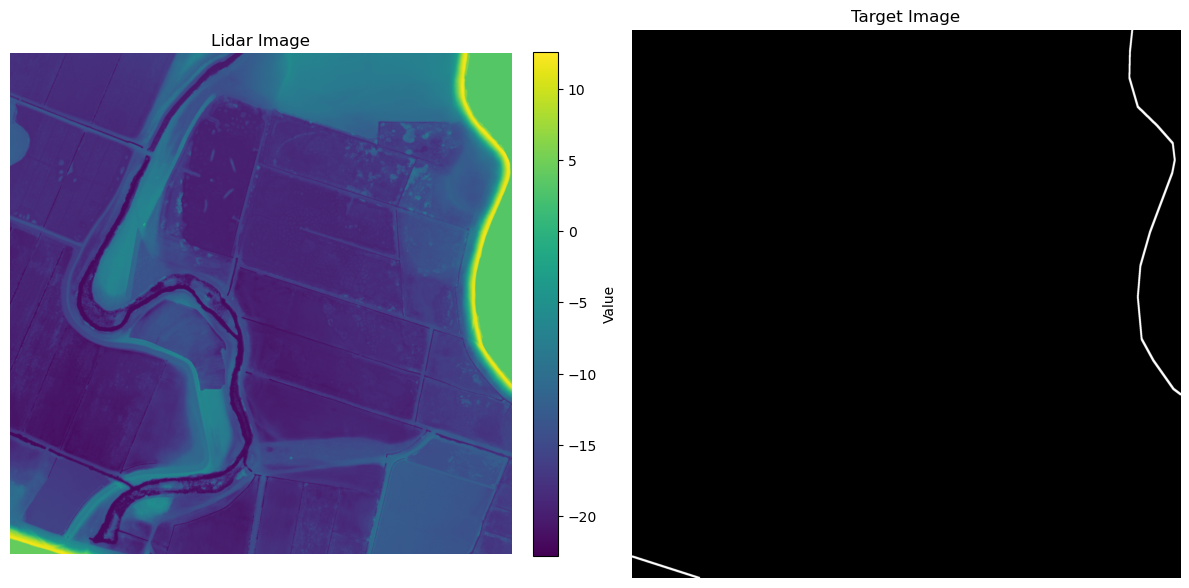

6


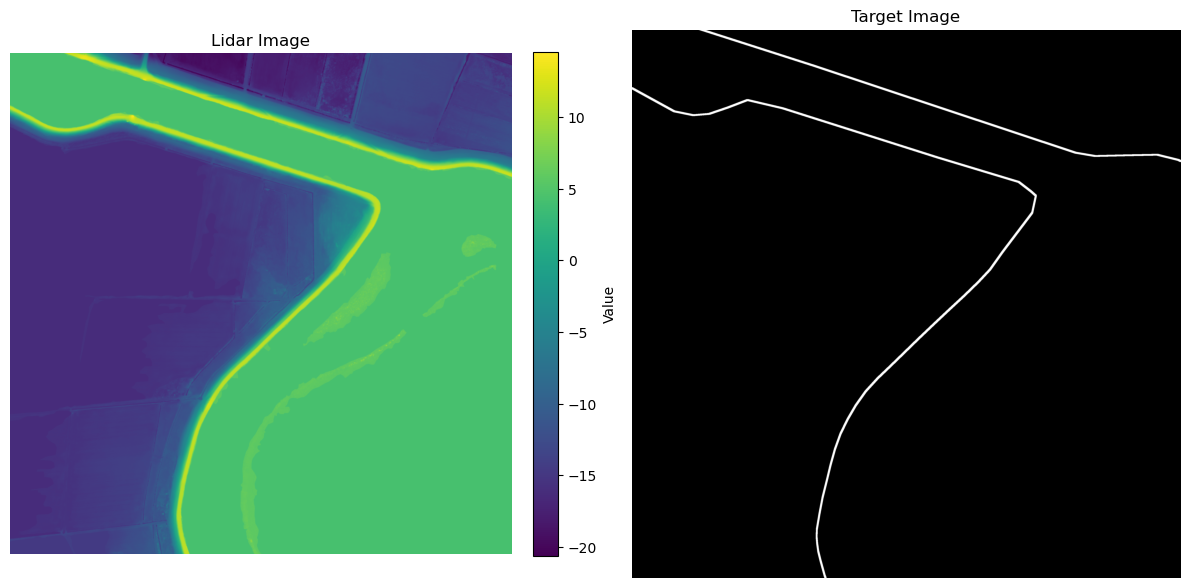

7


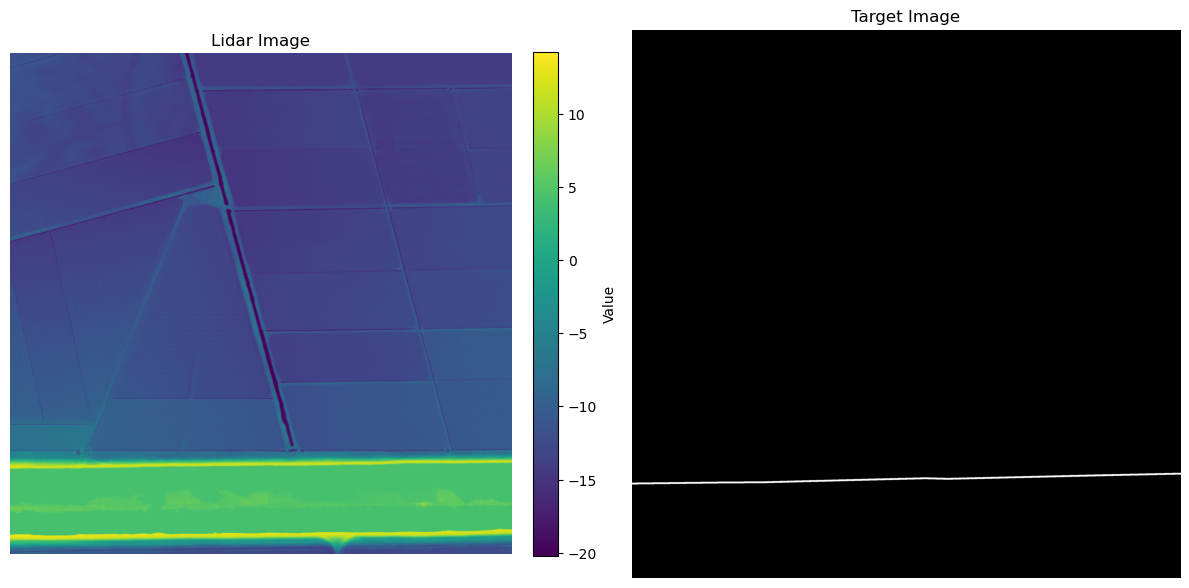

8


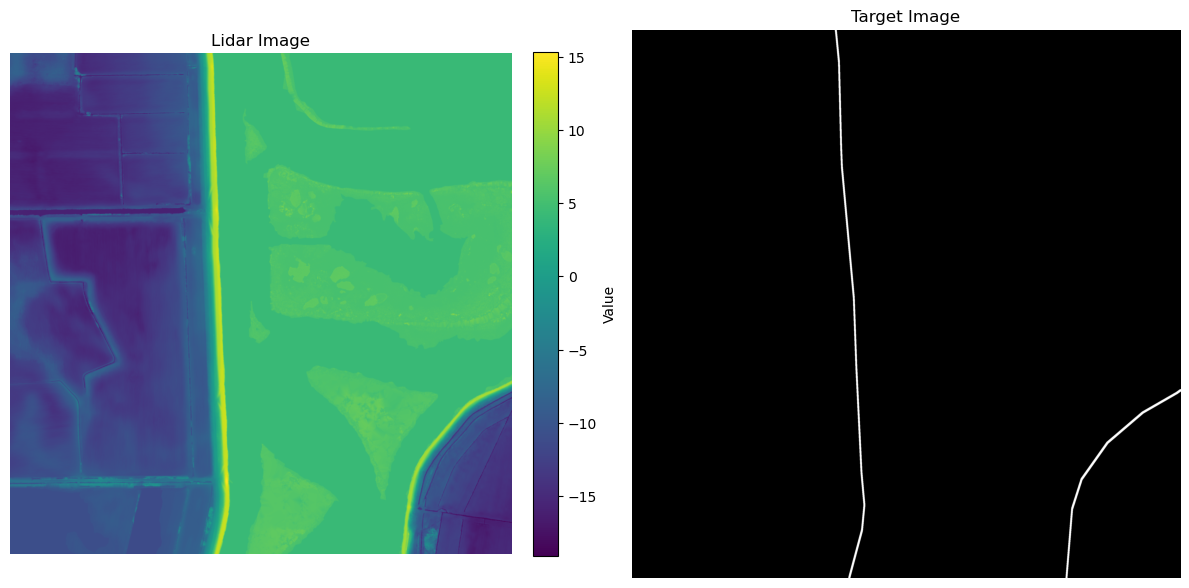

9


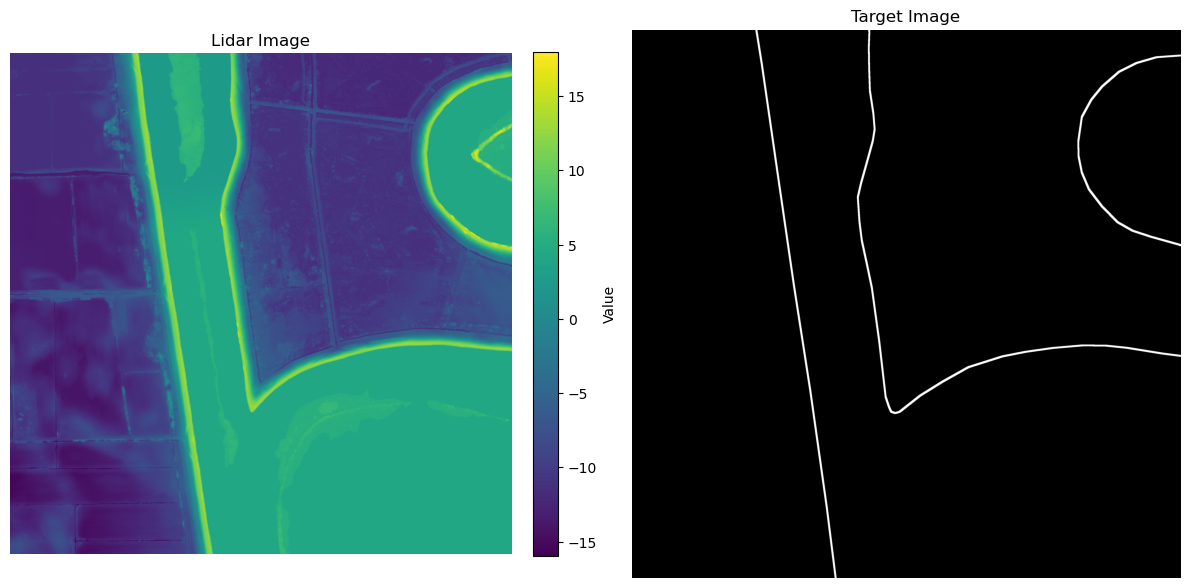

10


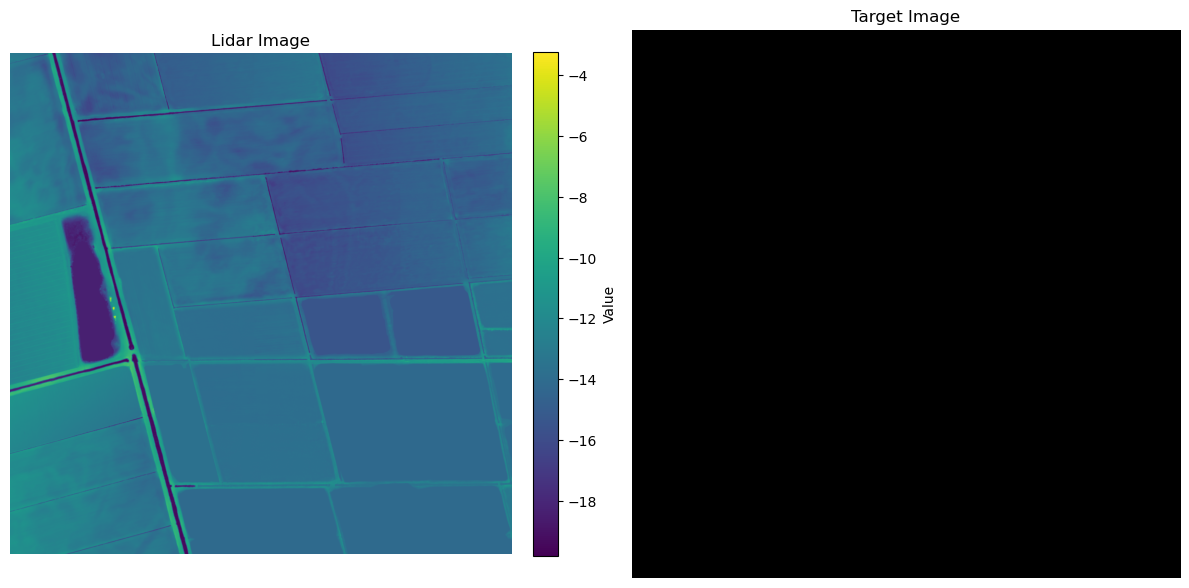

11


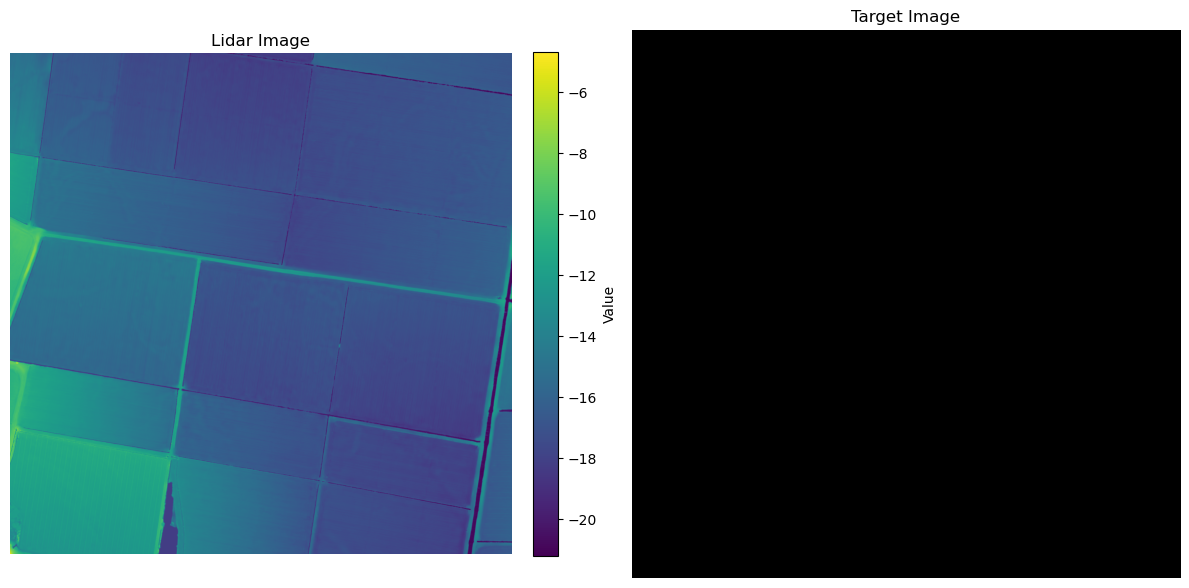

12


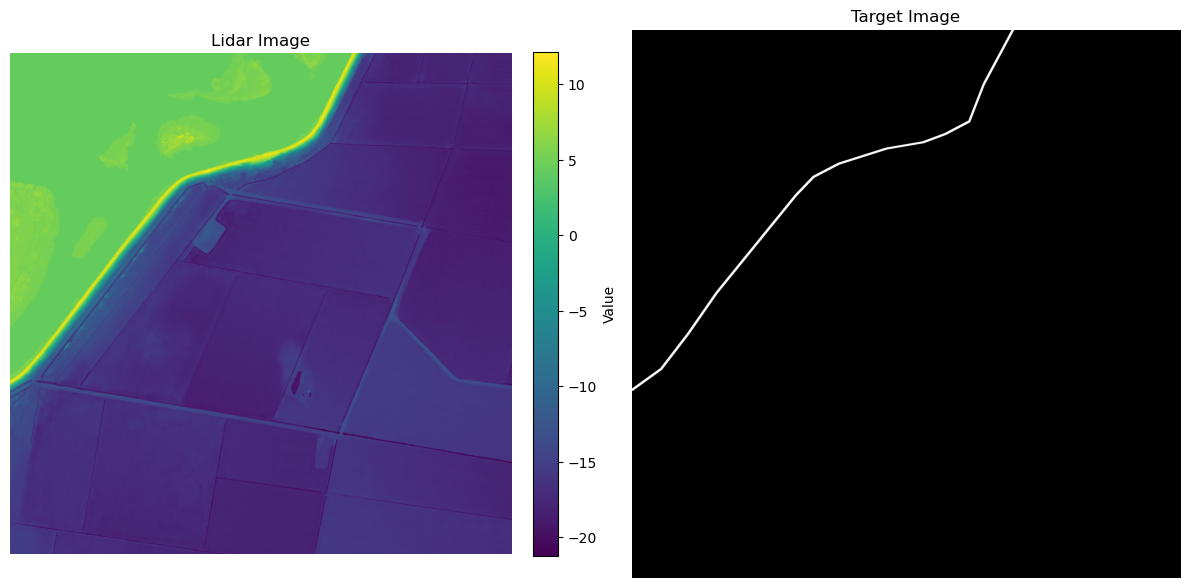

13


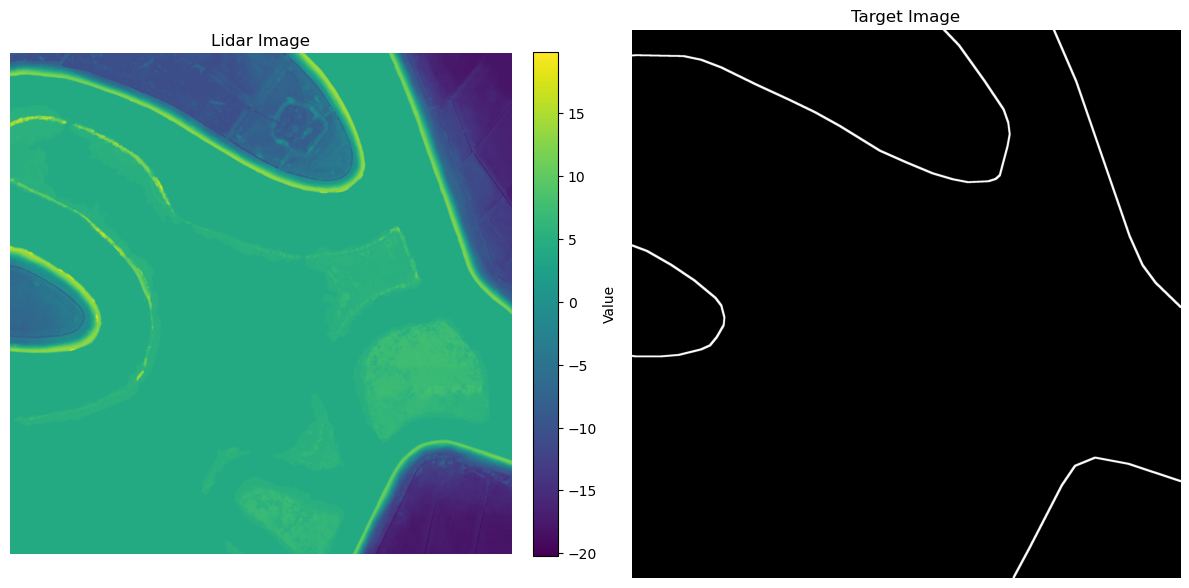

14


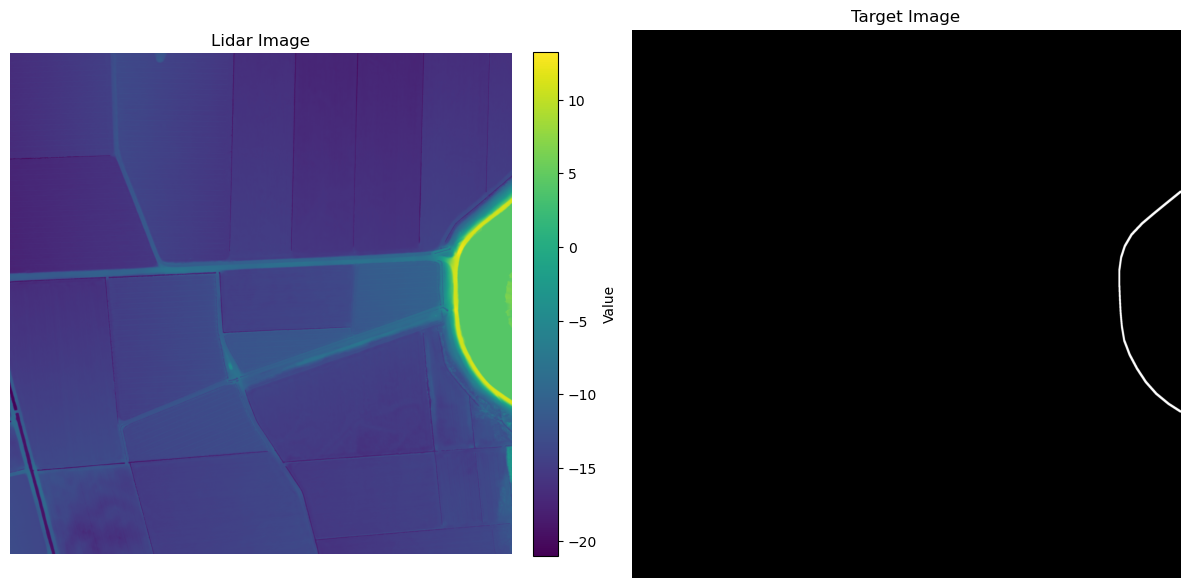

15


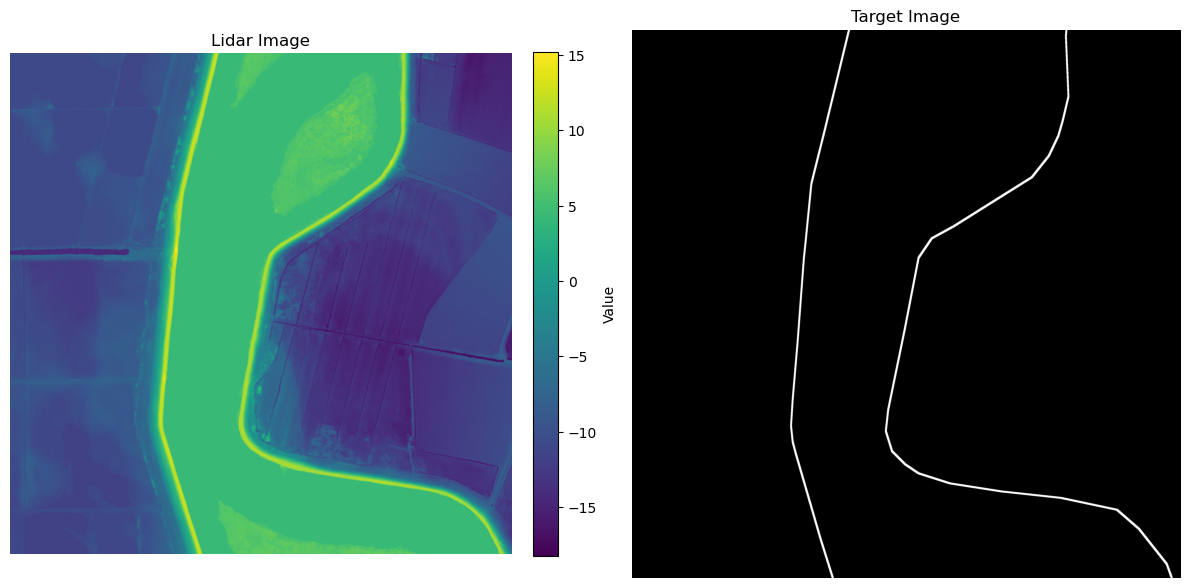

16


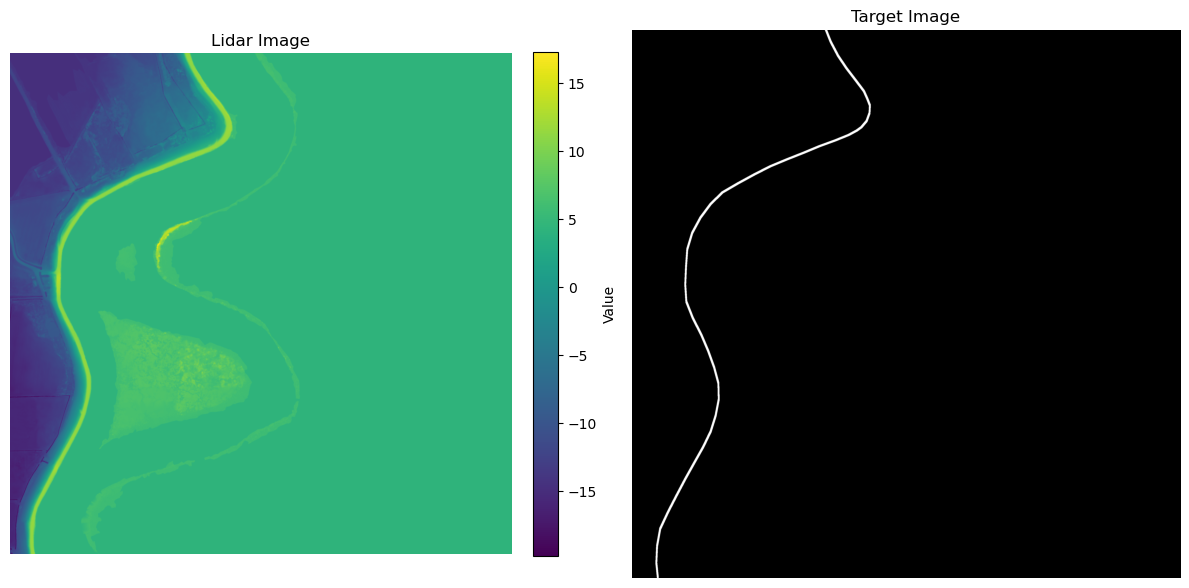

17


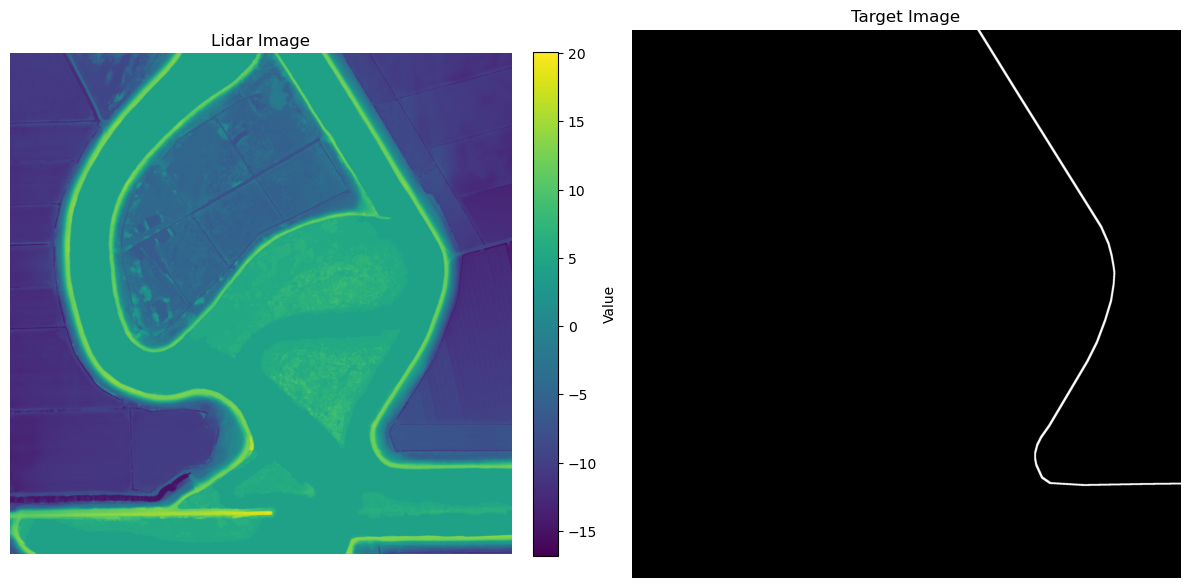

18


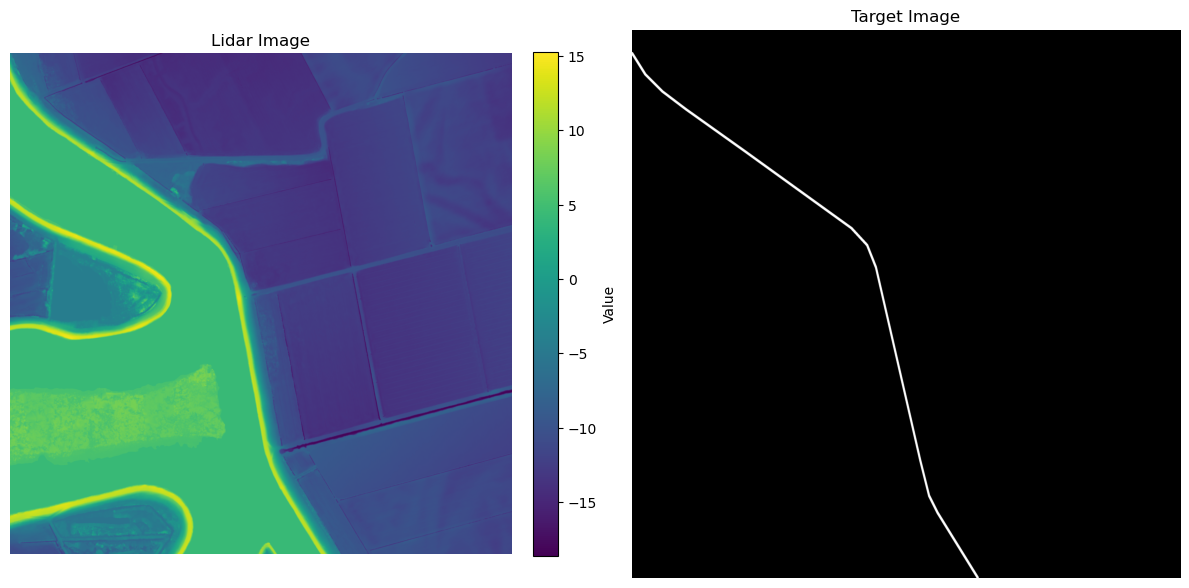

19


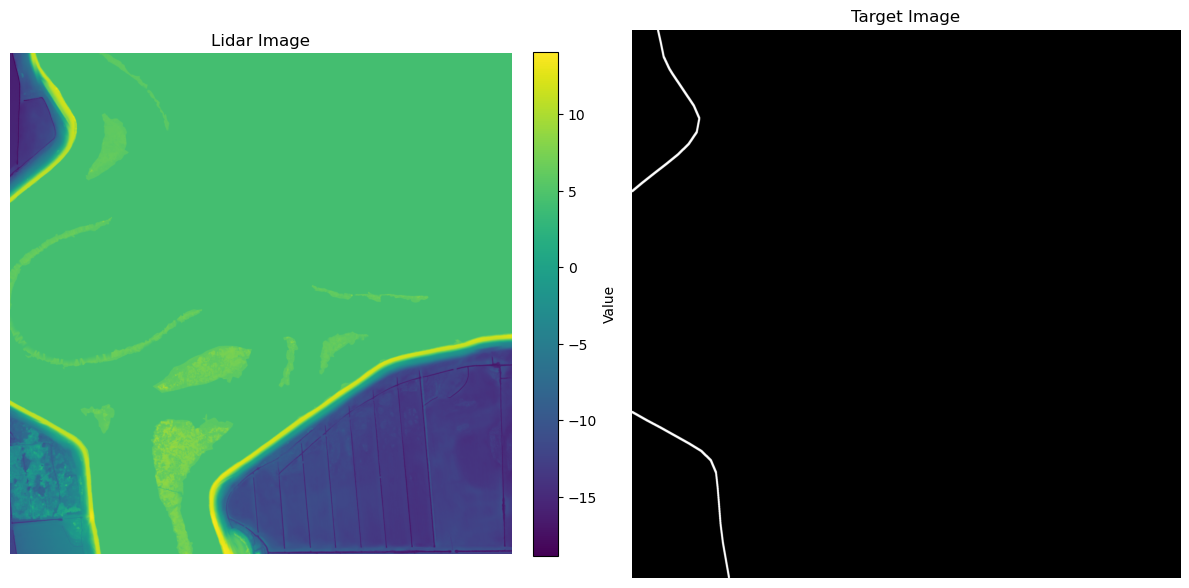

20


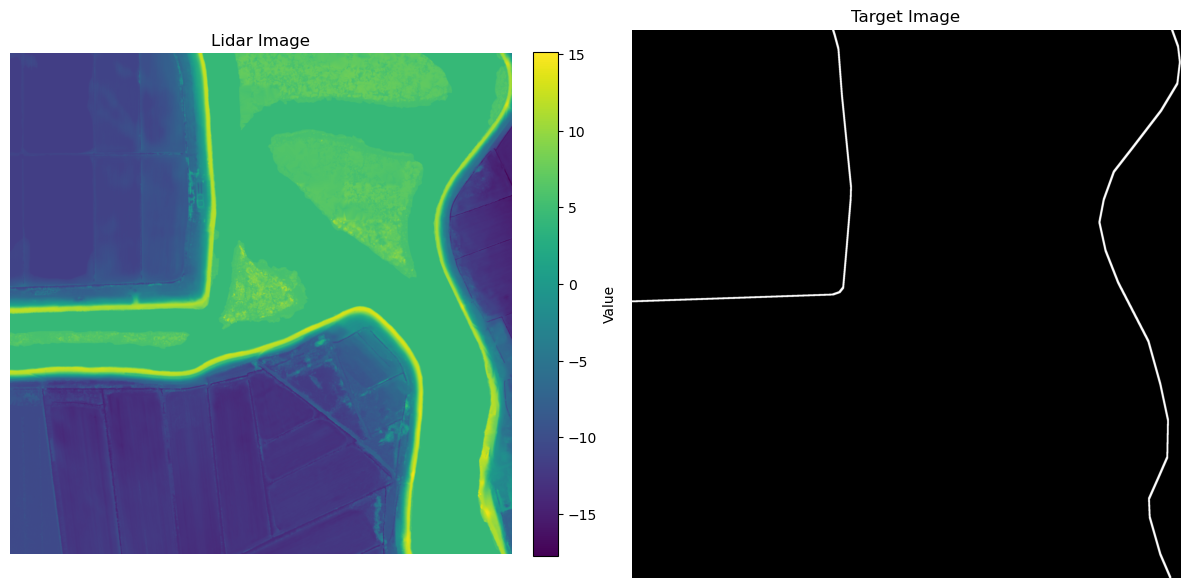

21


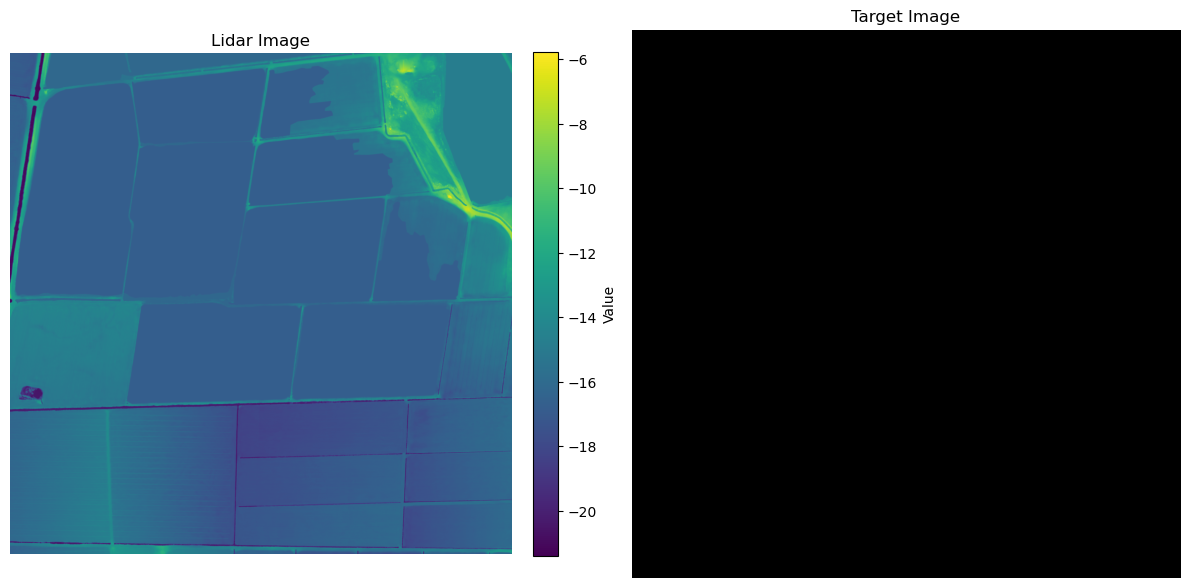

In [4]:
for ix in range(len(lidar_images_arr)):   
    print(ix)
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

    # Plot the first image
    im = axes[0].imshow(lidar_images_arr[ix], cmap="viridis")
    axes[0].set_title("Lidar Image")
    axes[0].axis("off")

    cbar = fig.colorbar(im, ax=axes[0], orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label("Value")  # Optional: Label for the colorbar

    # Plot the second image
    axes[1].imshow(targets_arr[ix], cmap=ListedColormap(["white", "black"]), vmin=0, vmax=1)  # Explicitly map 0->white, 1->black
    axes[1].set_title("Target Image")
    axes[1].axis("off")  # Hide axes for cleaner visualization

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [5]:
# Here, I selected by eye, which images have missing levees and which don't
# the good images do not miss any levees, while the bad images do
good_images_ix = [0, 1, 5, 6, 8, 9, 12, 13, 14, 15, 16]
bad_images_ix = [2, 3, 4, 7, 10, 11, 17, 18, 19, 20, 21]

In [6]:
good_images = lidar_images_arr[good_images_ix]
good_masks = targets_arr[good_images_ix]

bad_images = lidar_images_arr[bad_images_ix]
bad_masks = targets_arr[bad_images_ix]

good_images.shape, good_masks.shape, bad_images.shape, bad_masks.shape

((11, 3000, 3000), (11, 3000, 3000), (11, 3000, 3000), (11, 3000, 3000))

In [7]:
good_dataset = SegmentationDataset(good_images, good_masks, transform=None, split=True, patch_size=256, final_size=256, overlap=6)

In [8]:
good_dataset.images[0].shape[-1]

256

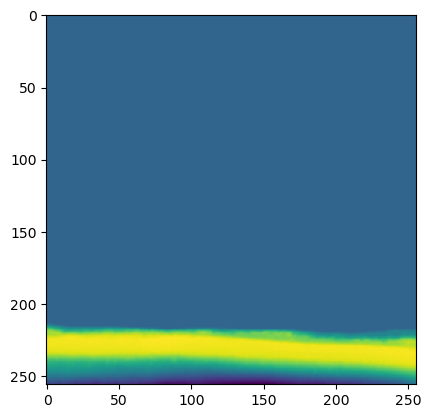

In [9]:
a, b = good_dataset[10]
plt.imshow(a.squeeze(), cmap="viridis")

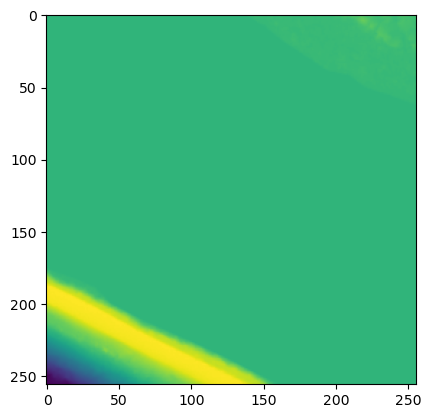

In [10]:
a, b = good_dataset[16]
plt.imshow(a.squeeze(), cmap="viridis")

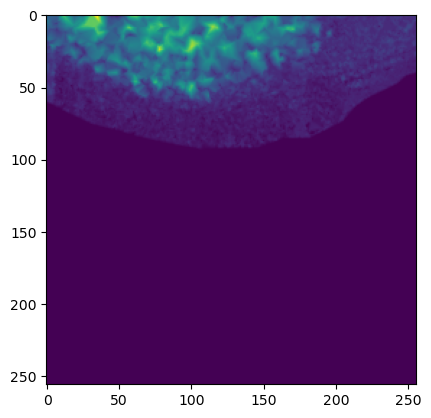

In [11]:
a, b = good_dataset[17]
plt.imshow(a.squeeze(), cmap="viridis")

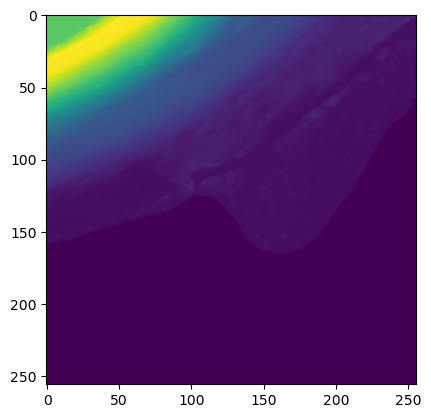

In [12]:
a, b = good_dataset[17+12]
plt.imshow(a.squeeze(), cmap="viridis")

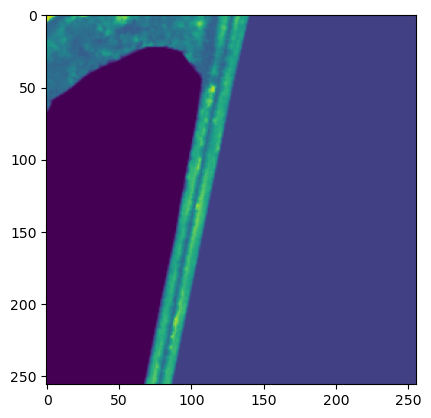

In [13]:
a, b = good_dataset[18+12]
plt.imshow(a.squeeze(), cmap="viridis")

In [14]:
bad_dataset = SegmentationDataset(bad_images, bad_masks, transform=None, split=True, patch_size=256, final_size=256, overlap=6)

In [15]:
torch.save(good_dataset, "../data/intermediate/w1-2-based-datasets/good_dataset_256_nooverlap.pth")
torch.save(bad_dataset, "../data/intermediate/w1-2-based-datasets/bad_dataset_256_nooverlap.pth")